In [797]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import xgboost as xgb
import xgbfir
import re

import sys
sys.path.insert(0, '/Users/JakeHeadings/Desktop/Kaggle/Machine Learning Algorithms/Rotation Forest')
import RotationForest

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [420]:
train = pd.read_csv('../input/train.csv', index_col='ID')
test = pd.read_csv('../input/test.csv', index_col='ID')

for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

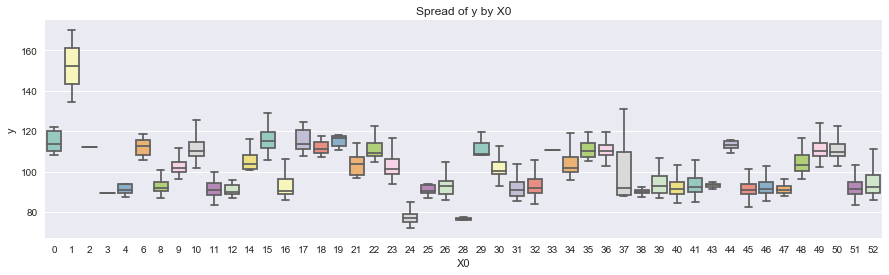

In [376]:
plt.figure(figsize=(15, 4))
sns.boxplot(x="X0", y="y", data=train, palette="Set3", showfliers=False)
plt.title('Spread of y by X0')
plt.show()

In [737]:
pattern = re.compile("^X[0-9]_")
if pattern.match('X10'):
    print ('yes')

In [746]:
features = []
for c in train.columns.values:
    if re.match("^X[0-9]_", c):
        2 + 2
    else:
        features.append(c)

In [747]:
corrmat = train[features].corr()

# Heatmap of first couple of features

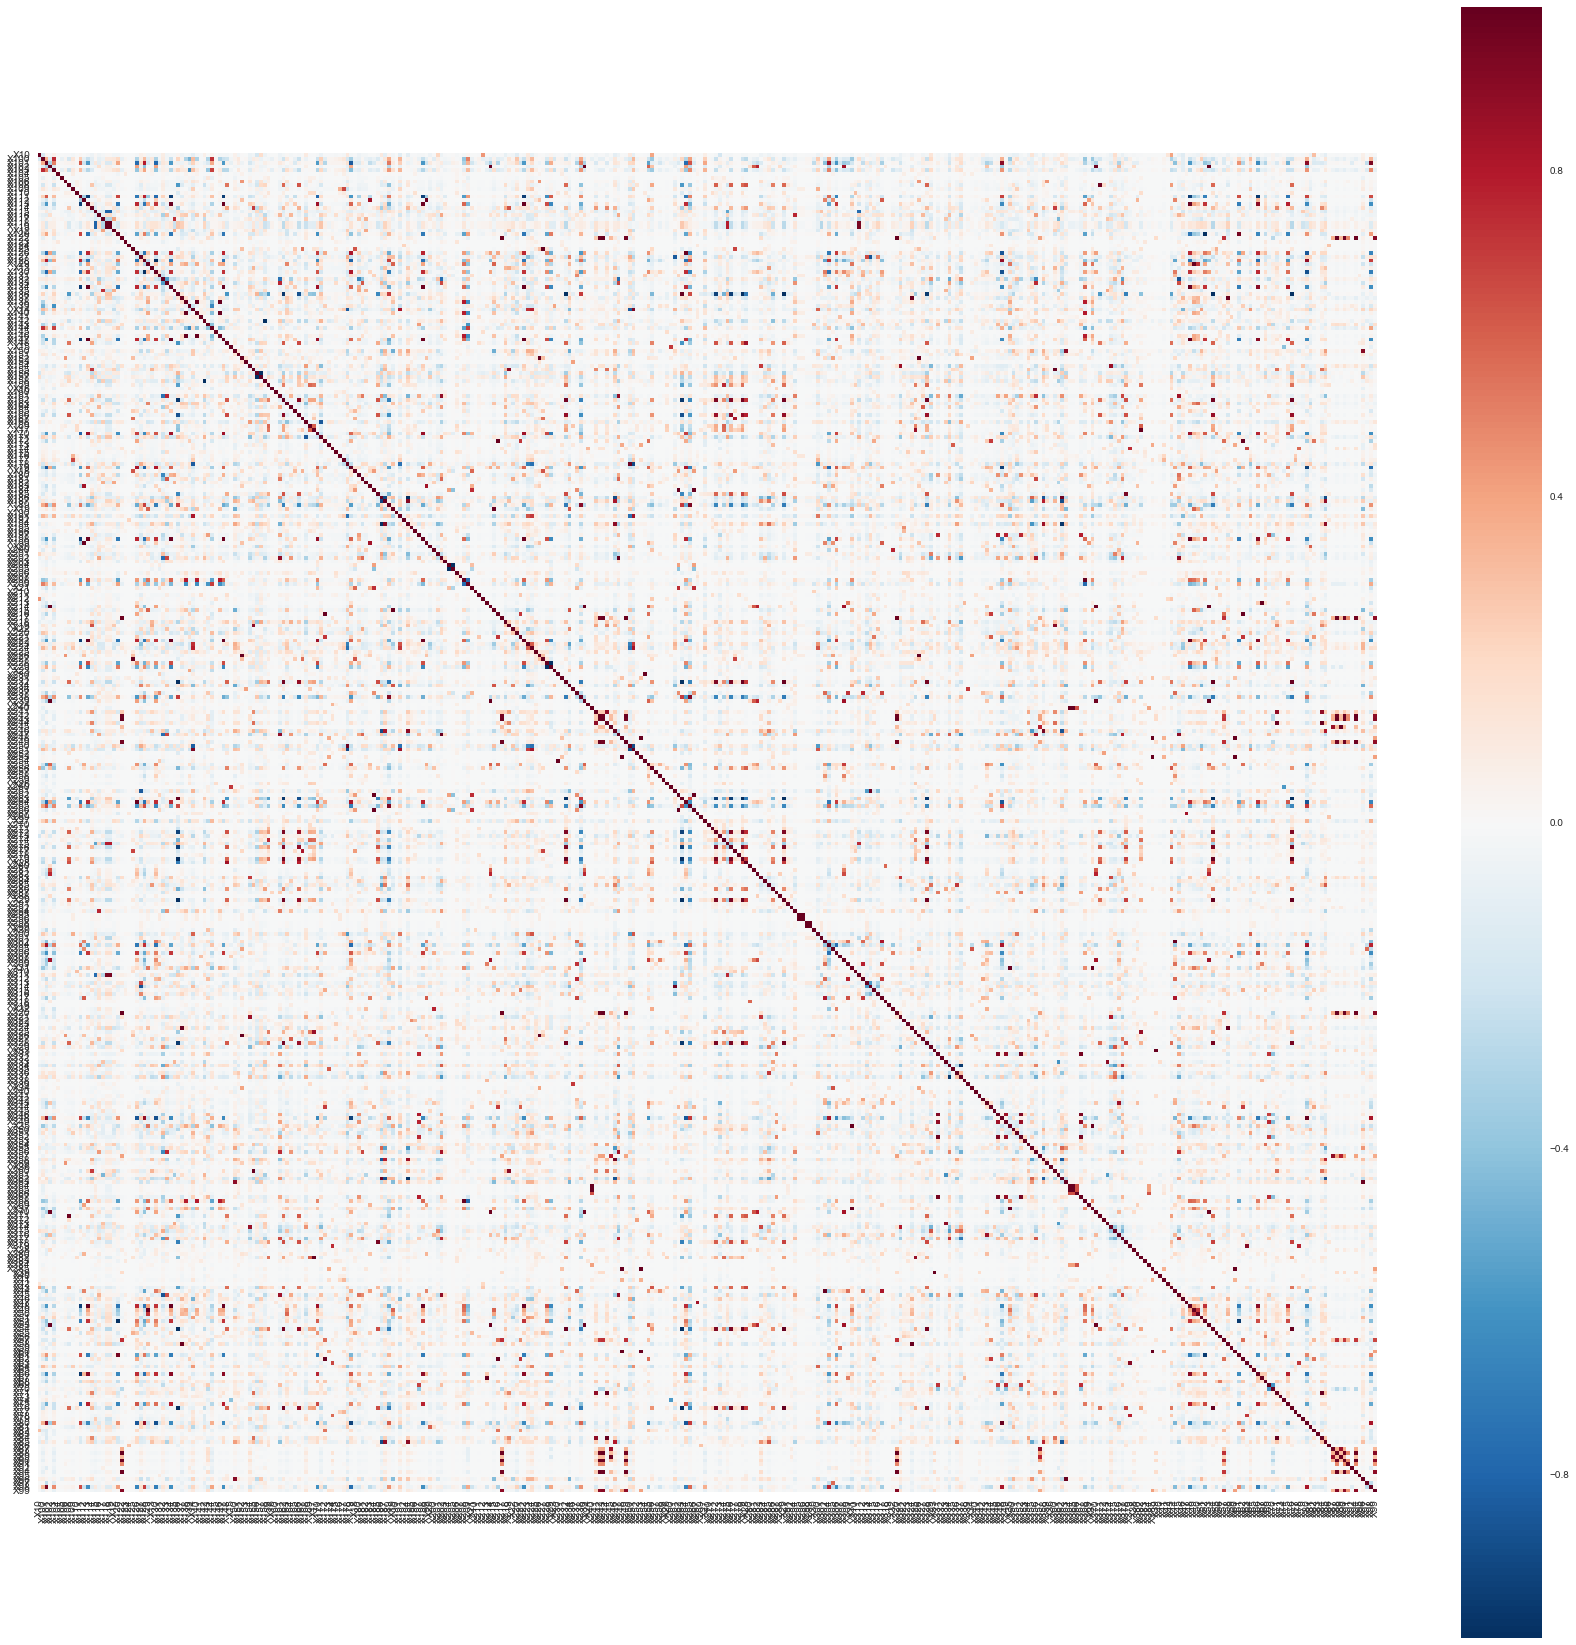

In [748]:
plt.figure(figsize=(30, 30))
sns.heatmap(corrmat, vmax=.8, square=True)

In [749]:
def get_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')

    return train, test

def one_hot(train_df, test_df):
    
    ntrain = len(train_df)
    
    # Remove useless variables
    for c in train_df.columns.values[10::]:
        if train_df[c].value_counts()[0] == ntrain:
            train_df.drop(c, axis=1, inplace=True)
            test_df.drop(c, axis=1, inplace=True)
    
    all_df = pd.concat([train_df, test_df])
    all_df = all_df.set_index('ID')
    
    cat = [] 
    for c in all_df.columns:
        if all_df[c].dtype == 'object':
            cat.append(c)
    print (cat)
            
    dummies = pd.get_dummies(all_df[cat])
    all_df.drop(cat, axis=1, inplace=True)
    all_df = pd.concat([all_df, dummies], axis=1)
        
    train_df = all_df.iloc[0:ntrain]
    test_df = all_df.iloc[ntrain::].drop('y', axis=1)
    
    return train_df, test_df

def label_encode(train_df, test_df):
    
    ntrain = len(train_df)
    
    # Remove useless variables
    for c in train_df.columns.values[10::]:
        if train_df[c].value_counts()[0] == ntrain:
            train_df.drop(c, axis=1, inplace=True)
            test_df.drop(c, axis=1, inplace=True)
    
    for c in train_df.columns:
        if train_df[c].dtype == 'object':
            lbl = LabelEncoder() 
            lbl.fit(list(train_df[c].values) + list(test_df[c].values)) 
            train_df[c] = lbl.transform(list(train_df[c].values))
            test_df[c] = lbl.transform(list(test_df[c].values))

    train_df = train_df.set_index('ID')
    test_df = test_df.set_index('ID')
            
    return train_df, test_df

train, test = get_data()
train, test = one_hot(train, test)
# train, test = label_encode(train, test)

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


In [750]:
y = train['y'].values
train.drop('y', axis=1, inplace=True)

In [710]:
train_cat = np.asarray(train.iloc[:, 0:8])
train_num = np.asarray(train.iloc[:, 8::])

In [724]:
scores = []

kf = KFold(5)
for train_index, test_index in kf.split(train, y):
    tr_cat, te_cat = train_cat[train_index], train_cat[test_index]
    tr_num, te_num = train_num[train_index], train_num[test_index]
    tr_y, te_y = y[train_index], y[test_index]
    
    skb = SelectKBest(f_regression, k=300)
    tr_num = skb.fit_transform(tr_num, tr_y)
    te_num = skb.transform(te_num)
    
    final_train = np.hstack((tr_num, tr_cat))
    final_test = np.hstack((te_num, te_cat))
    
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1,
                                 colsample_bytree=.7, reg_alpha=0,
                               reg_lambda=1, learning_rate=.1, subsample=.9)
    xgb_model.fit(final_train, tr_y)
    scores.append(r2_score(te_y, xgb_model.predict(final_test)))
print (np.mean(scores))

0.558465534632


In [622]:
cv = KFold(5, shuffle=True, random_state=0)
clf = make_pipeline(SelectKBest(f_regression, k=30), LinearRegression())
print (np.mean(cross_val_score(clf, train, y, cv=cv, scoring='r2')))

0.546607221161


In [620]:
cv = KFold(5, shuffle=True, random_state=0)
clf = make_pipeline(SelectKBest(f_regression, k=400), LinearSVR(C=0.4))
print (np.mean(cross_val_score(clf, train, y, cv=cv, scoring='r2')))

0.52900833509


# GBM One-hot

In [675]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=10, colsample_bytree=.3, reg_alpha=10,
                           reg_lambda=10, learning_rate=.1, subsample=.9)
clf = make_pipeline(SelectKBest(f_regression, k=400), xgb_reg)
scores = cross_val_score(clf, train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.565639991558


# Decomp and Manifold

In [791]:
pca = PCA(n_components=20)
pca_train = pca.fit_transform(train)

xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1, colsample_bytree=.8, reg_alpha=0,
                           reg_lambda=1, learning_rate=.1, subsample=.9)
scores = cross_val_score(xgb_reg, pca_train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.499488597897


In [793]:
mds = MDS(n_components=70, n_jobs=-1, verbose=1)
mds_train = mds.fit_transform(train)

xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1, colsample_bytree=.8, reg_alpha=0,
                           reg_lambda=1, learning_rate=.1, subsample=.9)
scores = cross_val_score(xgb_reg, mds_train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.468557785254


In [809]:
mds = LocallyLinearEmbedding(n_neighbors=40, n_components=50)
mds_train = mds.fit_transform(train)

xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1, colsample_bytree=.8, reg_alpha=0,
                           reg_lambda=1, learning_rate=.1, subsample=.9)
scores = cross_val_score(xgb_reg, mds_train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.376616125555


In [804]:
mds = Isomap(n_neighbors=20, n_components=50)
mds_train = mds.fit_transform(train)

xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1, colsample_bytree=.8, reg_alpha=0,
                           reg_lambda=1, learning_rate=.1, subsample=.9)
scores = cross_val_score(xgb_reg, mds_train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.436485813092


In [811]:
mds = SpectralEmbedding(n_components=200, n_jobs=-1)
mds_train = mds.fit_transform(train)

xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, min_child_weight=1, colsample_bytree=.8, reg_alpha=0,
                           reg_lambda=1, learning_rate=.1, subsample=.9)
scores = cross_val_score(xgb_reg, mds_train, y, cv=5, scoring='r2')
print (np.mean(scores))

0.48211809439


In [605]:
train_x, test_x, train_y, test_y = train_test_split(train, y, test_size=.2, random_state=6)

skb = SelectKBest(f_regression, k=400)
train_x = skb.fit_transform(train_x, train_y)
test_x = skb.transform(test_x)

# clf = xgb.XGBRegressor(n_estimators=150, max_depth=4, min_child_weight=1, colsample_bytree=.7,
#                        learning_rate=.1, subsample=.7)
clf = LinearSVR(C=0.5)
clf.fit(train_x, train_y)

preds = clf.predict(test_x)
print (r2_score(train_y, clf.predict(train_x)))
print (r2_score(test_y, preds))

0.524085422996
0.630166755048


[0]	train-rmse:100.869	test-rmse:100.868
[50]	train-rmse:96.0393	test-rmse:96.0386
[100]	train-rmse:91.445	test-rmse:91.4454
[150]	train-rmse:87.0747	test-rmse:87.0755
[200]	train-rmse:82.9196	test-rmse:82.9202
[250]	train-rmse:78.9677	test-rmse:78.9686
[300]	train-rmse:75.2092	test-rmse:75.2104
[350]	train-rmse:71.6358	test-rmse:71.6372
[400]	train-rmse:68.2376	test-rmse:68.2389
[450]	train-rmse:65.0064	test-rmse:65.0077
[500]	train-rmse:61.9347	test-rmse:61.9372
[550]	train-rmse:59.014	test-rmse:59.0169
[600]	train-rmse:56.2377	test-rmse:56.2407
[650]	train-rmse:53.5996	test-rmse:53.6033
[700]	train-rmse:51.0928	test-rmse:51.0964
[750]	train-rmse:48.7116	test-rmse:48.7158
[800]	train-rmse:46.4483	test-rmse:46.4532
[850]	train-rmse:44.2985	test-rmse:44.3055
[900]	train-rmse:42.257	test-rmse:42.2652
[950]	train-rmse:40.3183	test-rmse:40.3276
[1000]	train-rmse:38.4773	test-rmse:38.4879
[1050]	train-rmse:36.7293	test-rmse:36.7407
[1100]	train-rmse:35.0691	test-rmse:35.081
[1150]	train-rm

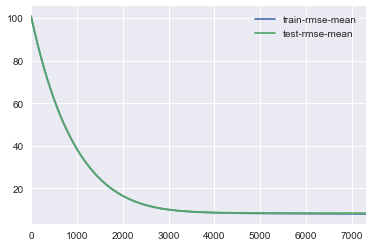

In [676]:
skb = SelectKBest(f_regression, k=400)
skb.fit(train, y)

my_train = pd.DataFrame(skb.transform(train), columns=train.columns.values[skb.get_support()])
my_test  = pd.DataFrame(skb.transform(test), columns=test.columns.values[skb.get_support()])

dtrain = xgb.DMatrix(my_train, y)
dtest = xgb.DMatrix(my_test)
    
xgb_params = { 
'eta': 0.001,
'max_depth': 4,
'subsample': 0.9,
'colsample_bytree': .3,
'reg_lambda': 10,
'reg_alpha': 10,
'objective': 'reg:linear',
'eval_metric': 'rmse',
'silent': 1
}

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=100000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [677]:
num_boost_rounds = len(cv_output)
model = xgb.train(xgb_params, dtrain, num_boost_round = num_boost_rounds)

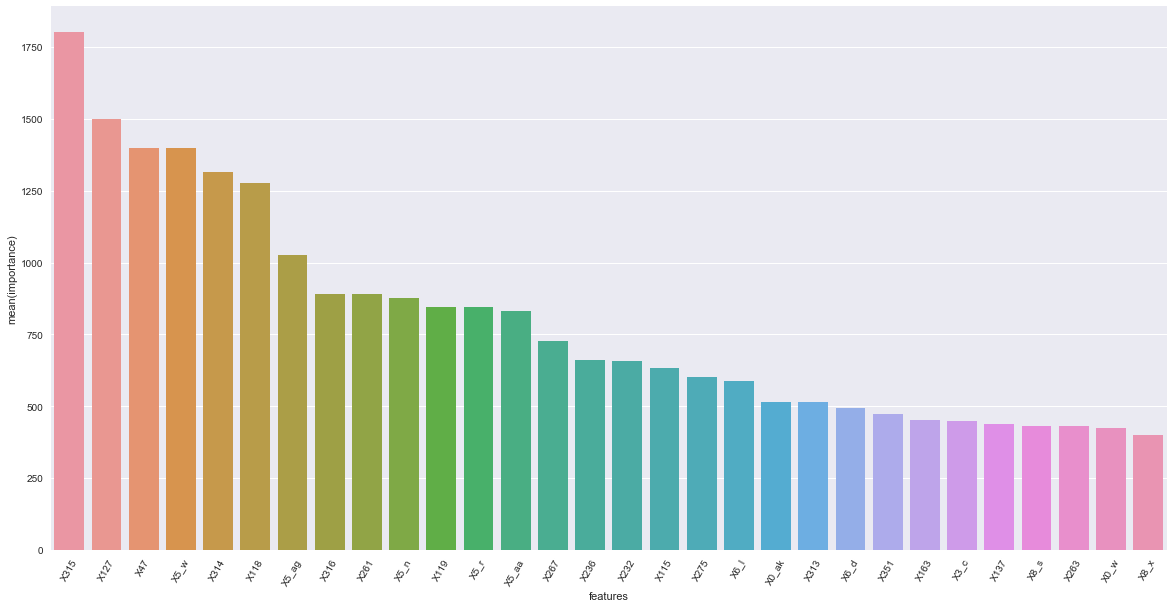

In [678]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

In [679]:
xgbfir.saveXgbFI(model, MaxInteractionDepth=4, OutputXlsxFile = '../output/Initial_fi.xlsx')

In [680]:
preds = model.predict(dtest)
sub = pd.DataFrame()
sub['ID'] = test.index
sub['y'] = preds
sub = sub.set_index('ID')
sub.to_csv('../output/xgb.csv')

# Submission experiments

In [528]:
model = LinearSVR(C=0.5)

skb = SelectKBest(f_regression, k=350)
my_train = skb.fit_transform(train, y)
my_test = skb.transform(test)

model.fit(my_train, y)
preds = model.predict(my_test)

/Users/JakeHeadings/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
/Users/JakeHeadings/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/JakeHeadings/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/JakeHeadings/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [535]:
sub = pd.DataFrame()
sub['ID'] = test.index
sub['y'] = preds
sub = sub.set_index('ID')

In [536]:
sub.to_csv('../output/svm.csv')

In [537]:
sub.head()

,y
ID,
1,63.755757
2,80.020619
3,65.866415
4,79.777603
5,110.622648
